# Financial Market Analysis

### Introduction
This project involves delving into the dynamic world of financial markets. I will handle time-series data and apply statistical methods to analyze stock prices, market trends, or economic indicators in NVIDIA historical data.

In [617]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
# Set options for displaying dataframes and figures
pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger('cmdstanpy')
logger.setLevel(logging.WARNING)
import yfinance as yf
import math
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates
import scipy.stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pylab
sns.set(style='white')
# from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import Dense, LSTM, Dropout

#### Analysis with the help of:
https://www.investing.com/equities/nvidia-corp-candlestick

https://finance.yahoo.com/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAL6NEGuxiw_sBTPeL5i0ZQC2enXDm8fMdMuywUSur9bpdR1jeyG2likZ_IlwV9rXjLf2ccqLJkIs7KVNEkthtHwAiFPv7ECpNebqOkdYbUJI4rc1i_CdBeAapYgtlpqvfZESKlg9QyZ40VisvhQS_KnJmXC-SgayO_JLigPkDrBR

https://www.kaggle.com/code/nahidahsan/time-series-analysis-and-forecasting

In [618]:
# Get the data
# Ticker symbol for Nvidia
ticker_symbol = "NVDA"
# Fetching data
nvidia_data = yf.Ticker(ticker_symbol)
# Fetching historical data
df = nvidia_data.history(period="6y")
print(df)

                                 Open        High         Low       Close  \
Date                                                                        
2018-04-04 00:00:00-04:00   53.217129   56.100624   52.967146   55.996670   
2018-04-05 00:00:00-04:00   56.580789   56.711969   54.078462   54.793766   
2018-04-06 00:00:00-04:00   53.766605   54.848226   52.736966   53.029026   
2018-04-09 00:00:00-04:00   53.660174   54.939801   53.115653   53.316135   
2018-04-10 00:00:00-04:00   55.620454   56.679796   55.048706   56.410011   
...                               ...         ...         ...         ...   
2024-03-27 00:00:00-04:00  931.119995  932.400024  891.229980  902.500000   
2024-03-28 00:00:00-04:00  900.000000  913.000000  891.929993  903.559998   
2024-04-01 00:00:00-04:00  902.989990  922.250000  892.039978  903.630005   
2024-04-02 00:00:00-04:00  884.479980  900.940002  876.200012  894.520020   
2024-04-03 00:00:00-04:00  884.260010  903.739990  884.000000  889.640015   

### About the data:
- Open: The opening price of the stock for that day.
- High: The highest price the stock reached during the trading day.
- Low: The lowest price the stock reached during the trading day.
- Close: The closing price of the stock for that day.
- Volume: The volume of shares traded during the trading day.
- Dividends: Any dividends paid out on that day.
- Stock Splits: Any stock splits that occurred on that day.

### Do I need Dividends and Stock Splits in my analysis?

- Dividends:

Dividends are payments made by a company to its shareholders out of its profits. They represent a portion of the company's earnings distributed to investors.
Including dividends in your analysis can provide a more complete picture of the total return on investment. Dividends can significantly contribute to overall returns, especially for long-term investors.
Dividend payments can also be indicative of a company's financial health and management's confidence in its future prospects.
However, if your analysis focuses solely on price movements or technical indicators, dividends may not be directly relevant. In such cases, you may choose to exclude dividends from your analysis.

- Stock Splits:

Stock splits involve dividing existing shares into multiple shares, effectively reducing the price per share proportionally. For example, in a 2-for-1 stock split, each existing share becomes two shares, and the price per share is halved.
Stock splits do not affect the total market value of an investor's holdings, but they can impact liquidity and trading activity.
Including stock splits in your analysis can be important for accurately interpreting historical price movements and calculating returns.
Stock splits can also be indicative of a company's growth and confidence in its future prospects. However, they may not always have a significant impact on stock performance.


In summary, whether dividends and stock splits are needed in your analysis depends on factors such as your investment strategy, time horizon, and specific objectives. For comprehensive analysis, especially for long-term investing, considering dividends and stock splits can provide valuable insights into overall returns and company performance. However, for certain types of analysis focused solely on price movements or short-term trading strategies, dividends and stock splits may be less relevant.


In [619]:
# finding unique values in Dividends and Stock Splits:
unique_values_dividends = df['Dividends'].unique()
print('The unique numbers for dividends are: ' , unique_values_dividends)
unique_values_dividends_count = df['Dividends'].value_counts()
print('The number of unique dividends are: ' , unique_values_dividends_count)

# finding unique values in Dividends and Stock Splits:
unique_values_Stock_Splits = df['Stock Splits'].unique()
print('The unique numbers for Stock Splits are: ' , unique_values_Stock_Splits)
unique_values_Stock_Splits_count = df['Stock Splits'].value_counts()
print('The number of unique Stock Splits are: ' , unique_values_Stock_Splits_count)

The unique numbers for dividends are:  [0.     0.0375 0.04  ]
The number of unique dividends are:  Dividends
0.0000    1486
0.0400      22
0.0375       2
Name: count, dtype: int64
The unique numbers for Stock Splits are:  [0. 4.]
The number of unique Stock Splits are:  Stock Splits
0.0    1509
4.0       1
Name: count, dtype: int64


The number of data in these 2 coloumns in compariosn to the whole data is insignificant, I think it is better to drop these 2 columns.

In [620]:
data=df.copy()
data = data.drop(columns=['Dividends', 'Stock Splits'])
data.reset_index(inplace=True)
data.describe()

,Open,High,Low,Close,Volume
count,1510.000000,1510.000000,1510.000000,1510.000000,1.510000e+03
mean,185.690495,189.119241,182.198948,185.856186,4.712811e+07
std,169.122550,172.148890,165.980037,169.279064,2.070042e+07
min,31.375399,32.241081,30.871868,31.521748,9.788400e+06
25%,61.554109,62.126570,60.504183,61.352958,3.328000e+07
50%,136.122660,138.276784,133.456754,135.773773,4.360375e+07
75%,232.003353,237.371547,225.226217,231.201340,5.730240e+07
max,958.510010,974.000000,935.099976,950.020020,2.511528e+08


In [621]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype                           
---  ------  --------------  -----                           
 0   Date    1510 non-null   datetime64[ns, America/New_York]
 1   Open    1510 non-null   float64                         
 2   High    1510 non-null   float64                         
 3   Low     1510 non-null   float64                         
 4   Close   1510 non-null   float64                         
 5   Volume  1510 non-null   int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(1)
memory usage: 70.9 KB


In [622]:
# Converting Date into DateTime format
data['Date']=pd.to_datetime(data['Date'])
# data.set_index(['Date'],inplace=True)

In [623]:
# Check for missing values
missing_val = data.isnull().sum()
missing_val_percentile = (100 * missing_val)/len(data)
missing_val_table = pd.concat([missing_val,missing_val_percentile], axis = 1)
missing_val_table = missing_val_table.rename(columns ={ 0: 'Missing Values', 1: 'Percentage'})
missing_val_table = missing_val_table.sort_values(by = 'Missing Values', ascending = False)
missing_val_table

,Missing Values,Percentage
Date,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0


There is no missing values.

## Explority Data Analysis

#### Candle Stick representation of Nvidia Stocks
A candlestick is a type of price chart used in technical analysis that displays the high, low, open, and closing prices of a security for a specific period. This visualization uses plotly you can zoom in and out using the range slider green means ascending and red means descending.

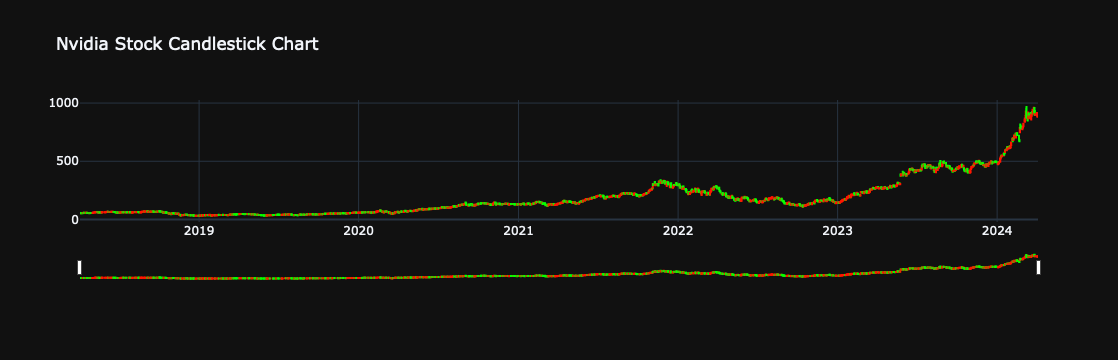

In [624]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'],
                high=data['High'],                     
                low=data['Low'],
                close=data['Close'],
                increasing_line_color= '#FF1700',
                decreasing_line_color= '#06FF00'
                    )])
fig.update_layout(title='Nvidia Stock Candlestick Chart',
                 template="plotly_dark",)
fig.show()

#### Observation:
- Overall Trend:
  
  The stock price of NVIDIA has experienced significant fluctuations over the years.
  
  Between 2019 and early 2023, the stock remained relatively stable with minor ups and downs.

- Bullish Trend in 2023:
  
  Starting around 2023, there is a noticeable upward trend in the stock price.
  
  Green candlesticks dominate during this period, indicating a bullish market for NVIDIA stocks.

- Recent Patterns:

  Some recent candlestick patterns include:

   - Bullish Engulfing on the 5-hour chart (current).  

   - Evening Doji Star on the 30-minute chart (March 27, 2024). 

   - Engulfing Bearish on the 1-day chart (March 8, 2024).
                                                                           
- Price Range:

  The stock price ranged from a low of 891.23 to a high of 932.40 recently.

#### What does it mean at all??

- Bullish Engulfing:
The bullish engulfing pattern is a reversal pattern that often occurs at the end of a downtrend.

The first candlestick is a small bearish candle (red or black) that represents a price decline.

The second candlestick is a large bullish candle (green or white) that completely engulfs the first candle.

The bullish engulfing pattern suggests a potential reversal from bearish to bullish sentiment.

Traders interpret this as a sign that buyers are taking control, and the price may start rising.

- Evening Doji Star:

The evening doji star is another reversal pattern, but it occurs after an uptrend.

The first candlestick is a large bullish candle.
    
The second candlestick is a doji (a small candle with almost equal open and close prices).

The third candlestick is a large bearish candle that closes below the midpoint of the first candle.
    
The evening doji star suggests a potential reversal from bullish to bearish sentiment.
    
It indicates that the uptrend may be losing momentum, and sellers might take control.

- Engulfing Bearish:
    
The engulfing bearish pattern is similar to the bullish engulfing but in the opposite direction.
    
It occurs at the end of an uptrend.
    
The first candlestick is a small bullish candle.
    
The second candlestick is a large bearish candle that completely engulfs the first candle.
    
The engulfing bearish pattern suggests a potential reversal from bullish to bearish sentiment.
    
Traders interpret this as a sign that sellers are gaining strength, and the price may start declining.

<Axes: >

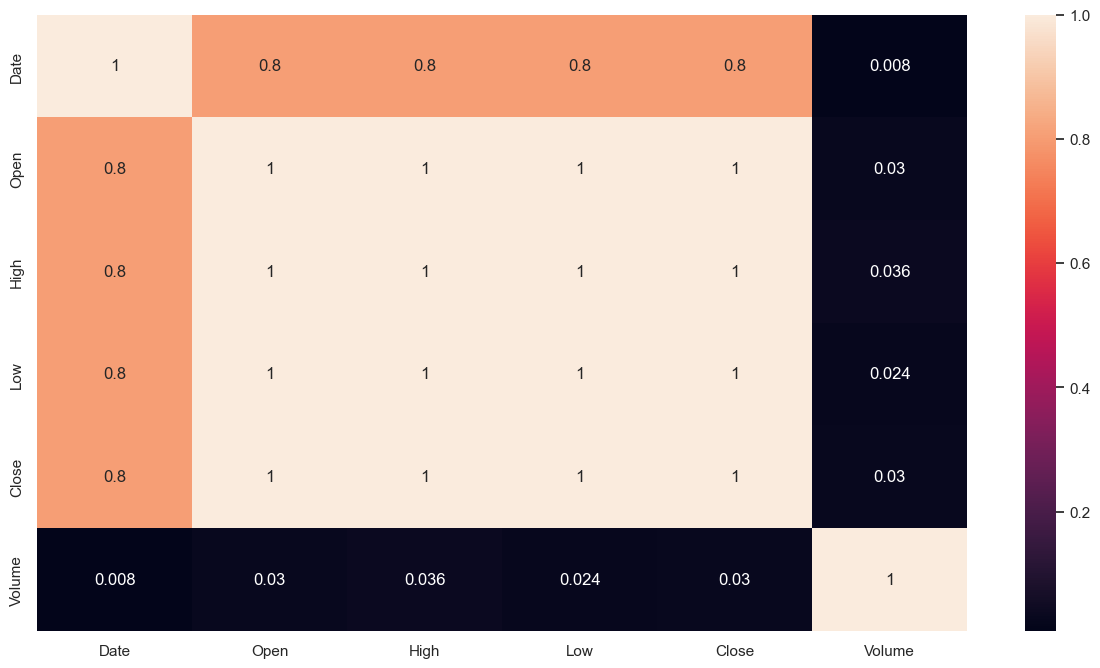

In [625]:
# Correlation
dt = data.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(dt,annot=True)

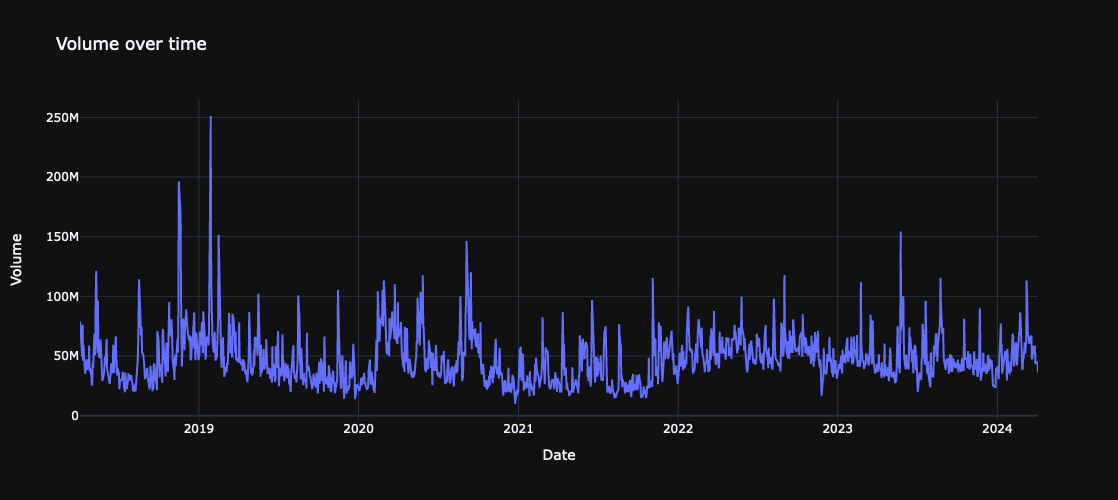

In [626]:
# Voluom over tome
fig = go.Figure([go.Scatter(x=df.index, y=df['Volume'])])
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
    title='Volume over time',
    template="plotly_dark",
)
fig.update_xaxes(title="Date")
fig.update_yaxes(title="Volume")
fig.show()

#### observation:

- Volume Fluctuations:
    The volume shows significant fluctuations over the years.

    Notably, there are spikes in volume around the years 2019 and midway between 2020 and 2021 and 2023 and 2024.

    These spikes indicate periods of high trading activity for NVIDIA stock.

- 2019 Volume Surge:
    In 2019, there was a substantial increase in trading volume.

    This surge could be related to significant events such as earnings reports, product launches, or market developments.

- 2021-2022 Activity:
  
    Between 2020 and 2021, there was another period of elevated volume.

    Investors and traders were actively buying and selling NVDA shares during this time.

- 2022-2023 Activity:
  
    Between 2022 and 2023, there was another period of elevated volume.

- 2023-2024 Activity:

    in the middle of 2023, there was another periode of evaluate volumne.

- Moderate Fluctuations:

    Apart from the spikes, the volume remained relatively stable with moderate fluctuations in other years.

    Trading volume reflects market participation and can provide insights into investor sentiment. High volume often accompanies significant price movements.

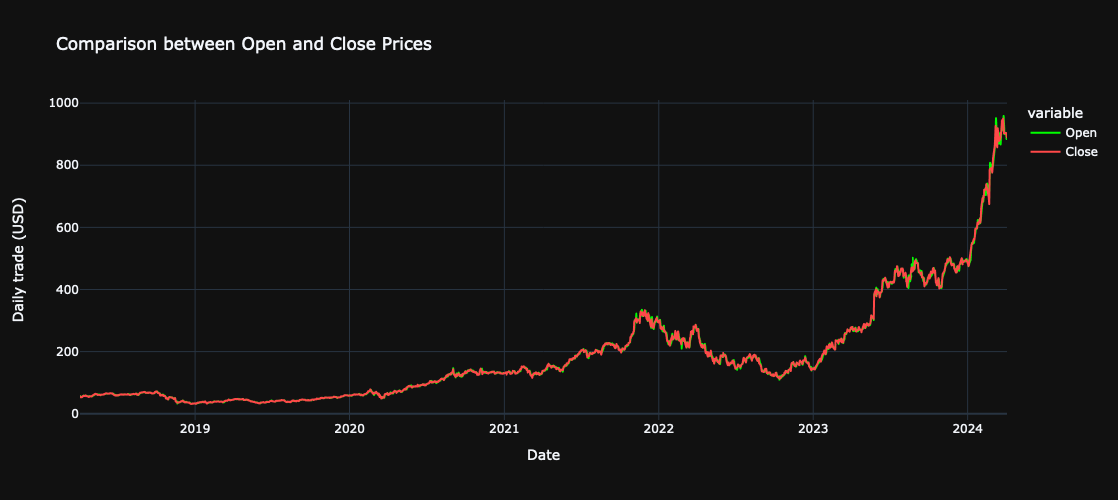

In [627]:
# Comparison between Opening & Closing Prices
fig = px.line(data, x="Date", y=["Open","Close"],template = 'plotly_dark',title='Comparison between Open and Close Prices')
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)
fig.data[0].line.color = "#00ff00"
fig.data[1].line.color = "#FF4949"
fig.update_yaxes(title="Daily trade (USD)")
fig.show()

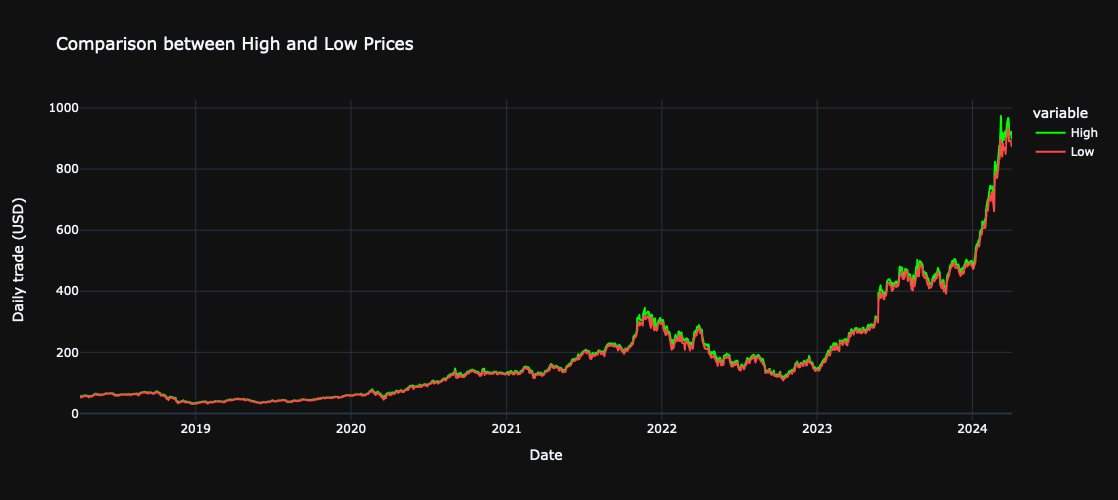

In [628]:
# Comparison between High & Low Prices
fig = px.line(data, x="Date", y=["High","Low"],template = 'plotly_dark',title='Comparison between High and Low Prices')
fig.update_layout(
    autosize=False,
    width=1000,
    height=500,
)
fig.data[0].line.color = "#00ff00"
fig.data[1].line.color = "#FF4949"
fig.update_yaxes(title="Daily trade (USD)")
fig.show()

#### Observation:

All open, close, high and low prices follow the same pattern.

In 2022, NVIDIA Corporation (NVDA) experienced a significant drop in its stock price. Here are some key reasons behind this decline:

1- Slowing Demand for Gaming Chips:

- Excess inventory of gaming chips in the retail channel led to weak profitability.
    
- As a result, NVIDIA had to clear channel inventory to make room for new products, including the RTX 40 series graphics-processing units (GPUs) for gaming.
    
2- Market Sentiment and Cyclical Nature:

- The semiconductor industry is cyclical and sensitive to market sentiment.
    
- Global semiconductor revenue was projected to decline by 3.6% in the following year, leading to uncertainty.

3- Boom-Bust Nature of the Business:

- The semiconductor business is characterized by boom-bust cycles due to supply-demand dynamics.
    
- Overproduction followed by oversupply can impact profitability and stock performance.
    
4- High Valuation and Uncertainty:

- NVIDIA’s stock had reached a peak market cap of $834 billion in the past.
    
- However, uncertainties related to the Fed’s interest rate decisions, inflation, and global economic conditions weighed on the sector.
    
- Analysts projected a decline in semiconductor revenue, affecting investor confidence.
    
5- New Product Launches and Industry Trends:

- NVIDIA’s performance is closely tied to product launches, technological advancements, and industry trends.
    
- The company’s ability to adapt to changing market dynamics influences its stock performance.
  
In summary, the drop in NVIDIA’s stock price in 2022 was influenced by a combination of market factors, demand fluctuations, and industry-specific challenges.

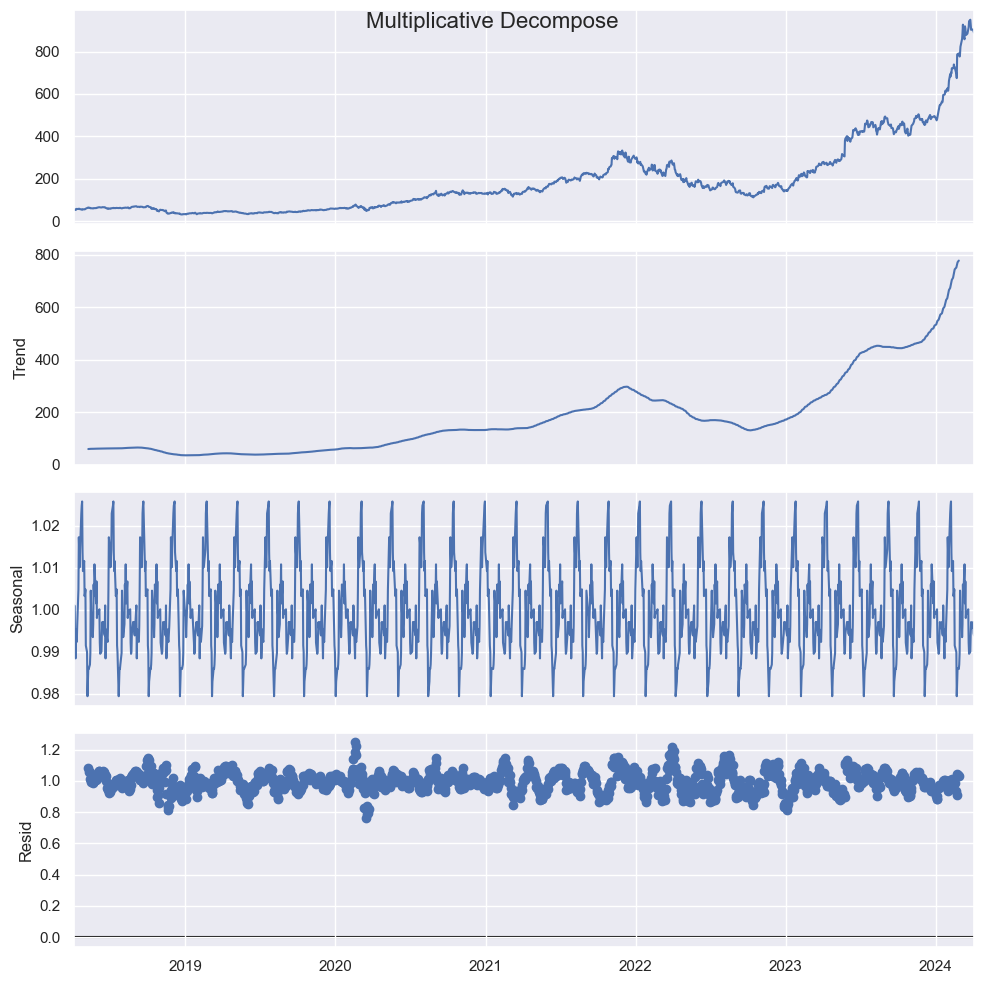

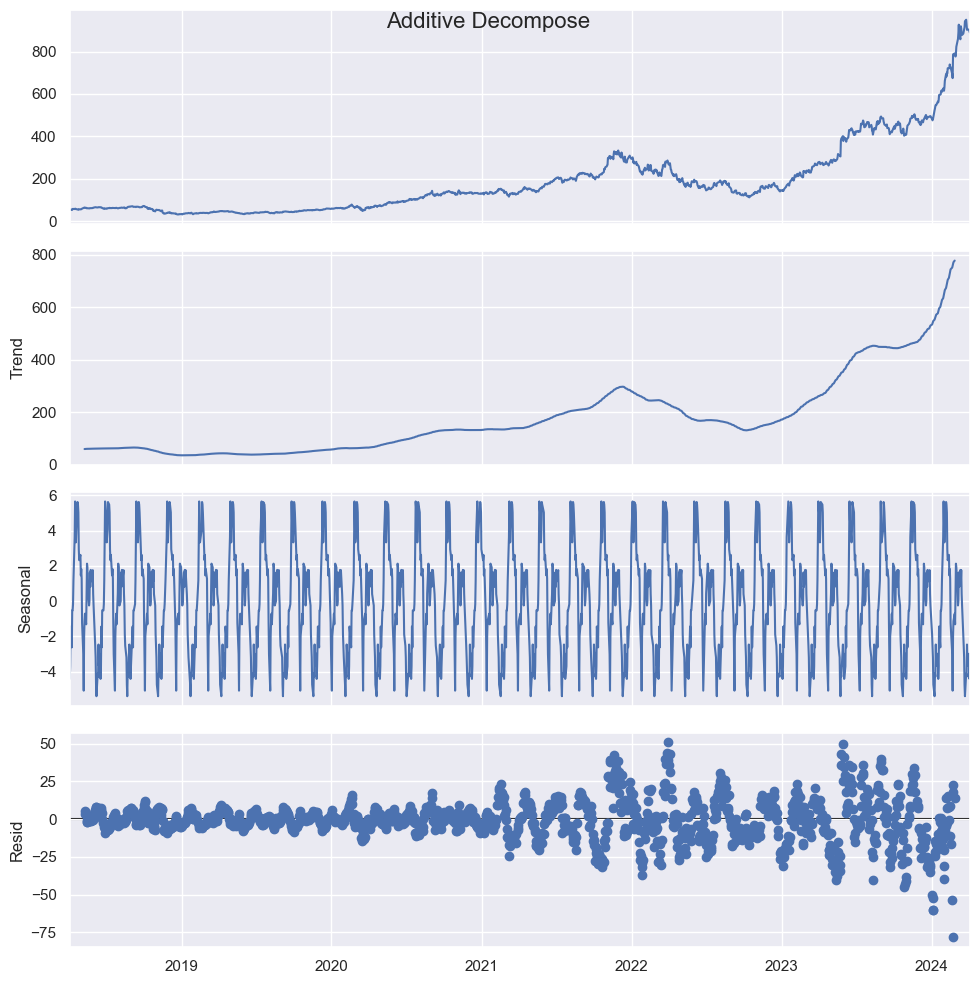

In [629]:
# Seasonal decomposition

plt.rcParams.update({'figure.figsize': (10,10)})
y = df['Close'].to_frame()
# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=16)
result_add.plot().suptitle('Additive Decompose', fontsize=16)
plt.show()

Stationarity refers to the statistical characteristics of a time series remaining constant over time. This doesn't imply that the series itself doesn't change over time, but rather that the way it changes doesn't vary. In other words, if a time series is stationary, it might exhibit trends or fluctuations, but these patterns remain consistent over time. Mathematically, this translates to the series following a linear function rather than a constant one. While the value of the series may vary with increasing time, the rate of change, represented by the slope of the linear function, remains constant.

In [630]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string(), '\n')          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

adf_test(data['Close'],title='Reliance Stock Data');

Augmented Dickey-Fuller Test: Reliance Stock Data
ADF test statistic         2.309162
p-value                    0.998961
# lags used               21.000000
# observations          1488.000000
critical value (1%)       -3.434752
critical value (5%)       -2.863484
critical value (10%)      -2.567805 

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


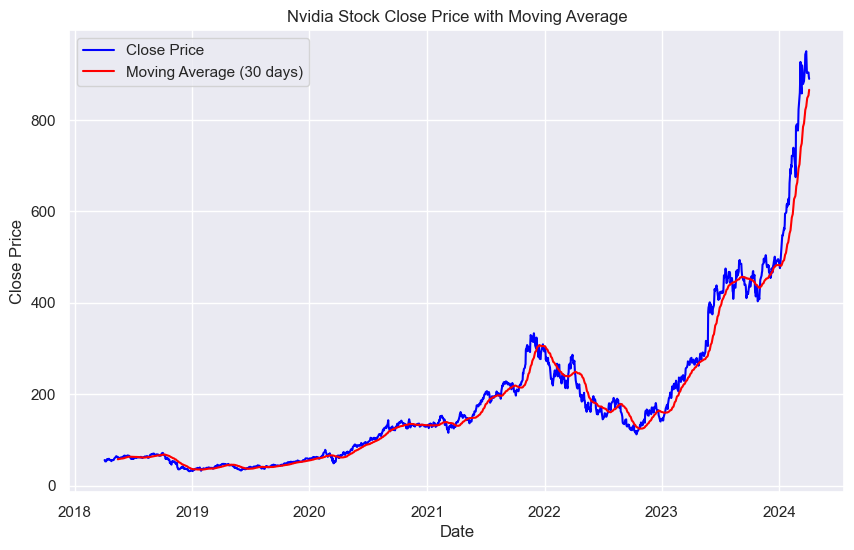

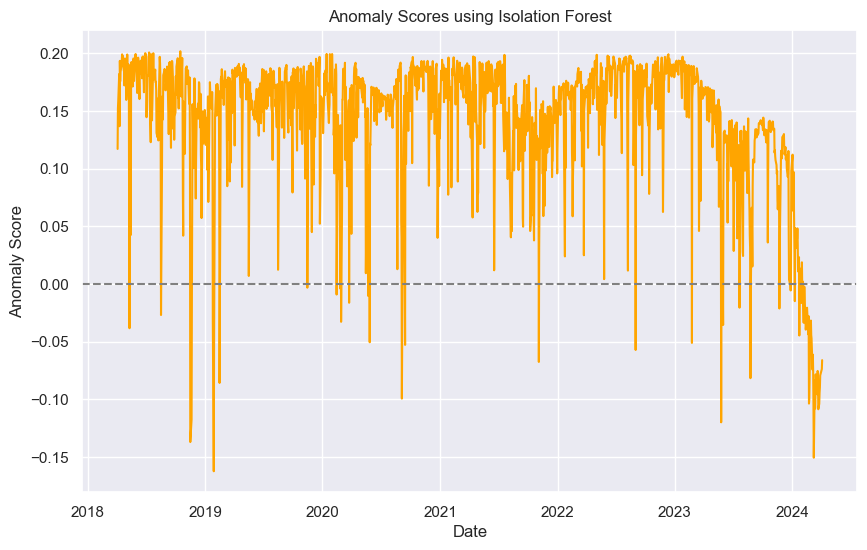

Detected Anomalies:
                          Date        Open        High         Low  \
27   2018-05-11 00:00:00-04:00   62.565572   64.300619   62.011148   
95   2018-08-17 00:00:00-04:00   62.643892   62.651322   60.362914   
159  2018-11-16 00:00:00-05:00   40.470454   42.289294   40.046716   
160  2018-11-19 00:00:00-05:00   40.091338   40.098776   35.839117   
161  2018-11-20 00:00:00-05:00   33.219872   38.225401   33.034023   
...                        ...         ...         ...         ...   
1505 2024-03-27 00:00:00-04:00  931.119995  932.400024  891.229980   
1506 2024-03-28 00:00:00-04:00  900.000000  913.000000  891.929993   
1507 2024-04-01 00:00:00-04:00  902.989990  922.250000  892.039978   
1508 2024-04-02 00:00:00-04:00  884.479980  900.940002  876.200012   
1509 2024-04-03 00:00:00-04:00  884.260010  903.739990  884.000000   

           Close     Volume  Moving_Average  Anomaly_Score  
27     62.998714  121445600             NaN      -0.038361  
95     60.632870 

In [631]:
# Finding anomalies
# Calculate moving average of 'Close' price
window = 30  # Adjust window size as needed
data['Moving_Average'] = data['Close'].rolling(window=window).mean()

# Plot original 'Close' price and moving average
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
plt.plot(data['Date'], data['Moving_Average'], label=f'Moving Average ({window} days)', color='red')
plt.title('Nvidia Stock Close Price with Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Prepare data for isolation forest
X = data[['Close', 'Volume']].values

# Fit isolation forest model
clf = IsolationForest(contamination=0.05)  # Adjust contamination parameter as needed
clf.fit(X)

# Predict anomalies (outliers)
anomaly_scores = clf.decision_function(X)
data['Anomaly_Score'] = anomaly_scores

# Plot anomaly scores
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Anomaly_Score'], color='orange')
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Anomaly Scores using Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Anomaly Score')
plt.show()

# Identify anomalies (outliers)
anomalies = data[data['Anomaly_Score'] < 0]

# Display detected anomalies
print('Detected Anomalies:')
print(anomalies)


#### Observation:
#### 1- Stock Price Trends:

The top plot shows the NVIDIA stock close price along with its 30-day moving average.

- Close Price (Blue Line):

    The blue line represents the actual closing price of NVIDIA stock.
        
    Notably, there has been significant growth in the stock price over time, especially after 2022.

    This upward trend suggests positive investor sentiment and potential company performance.
        
- Moving Average (Red Line):

    The red line represents the 30-day moving average.
        
    It smoothens out short-term fluctuations, emphasizing longer-term trends.
        
    When the moving average crosses above the actual price, it often signals a bullish trend.

#### 2- Anomaly Scores:

The bottom plot displays anomaly scores using the Isolation Forest algorithm.

The orange line shows fluctuating anomaly scores over time.
    
Noticeable peaks in the anomaly scores indicate periods of unusual stock price movements or anomalies.
        
- What Are Anomaly Scores?:

Anomaly scores quantify how unusual or unexpected a data point is relative to the overall dataset.
        
High anomaly scores indicate periods when the stock price behavior deviated significantly from the norm.

#### 3- Key observations:

- Interpreting Anomalies:

  -- Peaks in Anomaly Scores:

  These peaks represent specific time frames when NVIDIA’s stock exhibited unusual behavior.

  -- Potential Events:

     Anomalies might coincide with events such as:

     Earnings Reports: Positive or negative surprises in financial results.
  
     Product Launches: New product announcements or technological advancements.
  
     Market Shifts: Changes in industry trends, regulations, or global economic conditions.

1- Fourth-Quarter Earnings (Q4 2023):

- NVIDIA’s fourth-quarter earnings were significant for tech investors.

- The company’s revenue surged 265% year over year to $22.1 billion based on sales of its industry-leading graphics processing units (GPUs) for training and running AI applications.

- High Gross Margin (76%): Despite competition from rivals like Advanced Micro Devices (AMD), NVIDIA maintained a spectacularly high gross margin, indicating pricing power.

- These strong earnings reflect the company’s continued dominance in the AI industry1.

2- Diversification Efforts:
    To address potential challenges, NVIDIA is diversifying its strategy:
- Customized Chips: The company announced a $30 billion investment into a new business unit focused on helping cloud computing clients make customized chips. This move leverages economies of scale for niche use cases not well served by general-purpose chips.
  
- Software Focus: NVIDIA is also betting on software through its supercomputer DGX Cloud. This platform helps clients create and run AI applications without building their own infrastructure1.

3- Valuation and Affordability:

- Despite its impressive growth and future-proofing efforts, NVIDIA’s shares still trade at a reasonable valuation of 33 times forward earnings.
- This valuation is slightly higher than the S&P 500 average of 28.
- Investors find NVIDIA compelling due to its rock-solid economic moat, high-margin opportunities, and expansion into synergistic areas1.
  
4- AI-Chip Success and Free Cash Flow:
- Bank of America predicts that NVIDIA has 42% potential upside in 2024.
- The company is targeting free cash flow of $100 billion over the next two years, which will fuel new growth initiatives2.

5- Financial Events:
- NVIDIA presented at the following events for the financial community:
- Morgan Stanley Technology, Media and Telecom Conference 2024 on March 4.
- vCowen’s 44th Annual Health Care Conference on March 5.
  
( https://finance.yahoo.com/news/63-2024-where-nvidias-soaring-160700899.html

https://markets.businessinsider.com/news/stocks/nvidia-2024-outlook-nvda-stock-price-100-billion-cash-flow-2024-1

https://investor.nvidia.com/news/press-release-details/2024/NVIDIA-Announces-Upcoming-Events-for-Financial-Community/default.aspx)

In summary, NVIDIA’s strong earnings, diversification efforts, reasonable valuation, and upcoming events contribute to its positive outlook.

#### Trading Opportunities:

Traders can use these anomalies to identify potential trading opportunities.

Adjust strategies based on abnormal price movements.


### Using Fbprophet to forcast the next year

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


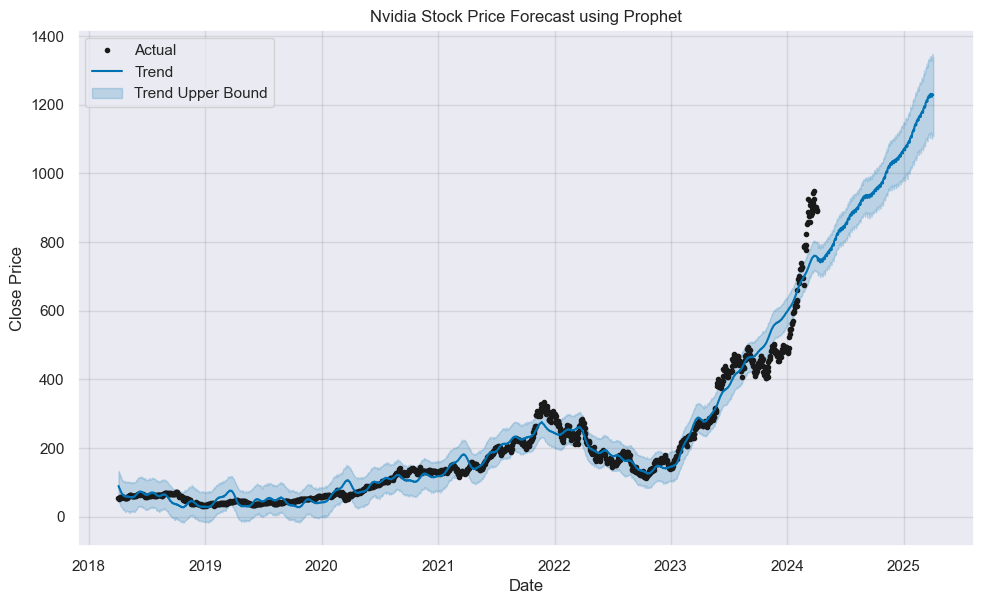

In [632]:
# Applying prophet (fbprophet) for forecasting future trends.
# Rename columns as required by prophet
data_pr = data.copy()

data_pr['Date'] = pd.to_datetime(data_pr['Date'])
data_pr.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
data_pr['ds'] = pd.to_datetime(data_pr['ds']).dt.tz_localize(None)


# Initialize Prophet model
model = Prophet()

# Fit the model
model.fit(data_pr)

# Define future timeframe for forecasting
future = model.make_future_dataframe(periods=365)  # Forecast for 1 year (365 days)

# Forecast future trends
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast, xlabel='Date', ylabel='Close Price')
plt.legend(["Actual", "Trend", "Trend Upper Bound", "Trend Lower Bound", "Forecast"])
plt.title('Nvidia Stock Price Forecast using Prophet')
plt.show()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Year: 2021, MAE: 84.62137258483753


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Year: 2022, MAE: 239.4248026529015


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Year: 2023, MAE: 431.22494352065763
Year: 2024, MAE: 170.15813957828468


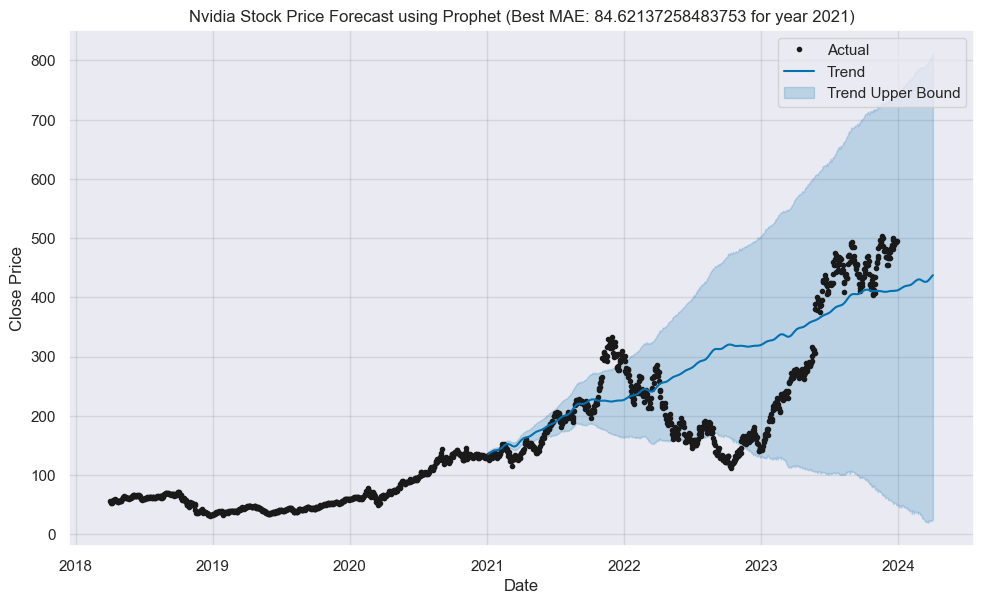

In [633]:
# Manually Evaluate Forecast Model for different years
data_pr_test = data.copy()
data_pr_test['Date'] = pd.to_datetime(data_pr_test['Date']).dt.tz_localize(None)


years_of_interest = [2021, 2022, 2023, 2024]  # Add more years as needed

best_mae = float('inf')
best_year = None
best_forecast = None

for year in years_of_interest:
    # Split the data into training and testing sets
    train = data_pr_test[data_pr_test['Date'] < str(year)].copy()
    test = data_pr_test[data_pr_test['Date'] >= str(year)].copy()

    # Initialize Prophet model
    model = Prophet()

    # Rename columns as required by Prophet
    train.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
    test.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

    # Fit the model using training data
    model.fit(train)

    # Define future timeframe for forecasting (same period as test data)
    future = pd.DataFrame({'ds': test['ds']})

    # Forecast future trends
    forecast = model.predict(future)

    # Calculate MAE
    mae = mean_absolute_error(test['y'], forecast['yhat'])
    print(f'Year: {year}, MAE: {mae}')

    # Compare and update best MAE
    if mae < best_mae:
        best_mae = mae
        best_year = year
        best_forecast = forecast

# Plot the best forecast
fig = model.plot(best_forecast, xlabel='Date', ylabel='Close Price')
plt.legend(["Actual", "Trend", "Trend Upper Bound", "Trend Lower Bound", "Forecast"])
plt.title(f'Nvidia Stock Price Forecast using Prophet (Best MAE: {best_mae} for year {best_year})')
plt.show()

INFO:prophet:Making 6 forecasts with cutoffs between 2020-07-12 00:00:00 and 2022-12-29 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

     horizon           mse        rmse         mae      mape     mdape  \
0    37 days   2349.721351   48.473924   33.485956  0.175838  0.078986   
1    38 days   2396.295920   48.951976   34.066056  0.178684  0.082706   
2    39 days   2524.552829   50.244928   35.111773  0.183040  0.096856   
3    40 days   2604.298616   51.032329   35.503659  0.184268  0.084781   
4    41 days   2698.566573   51.947729   36.075433  0.186056  0.095039   
..       ...           ...         ...         ...       ...       ...   
324 361 days  70632.982173  265.768663  204.868802  0.773665  0.504764   
325 362 days  72385.848517  269.046183  207.862313  0.776641  0.507754   
326 363 days  72480.449024  269.221933  208.201368  0.772925  0.509374   
327 364 days  72897.866157  269.996048  208.707433  0.774877  0.511511   
328 365 days  73852.944070  271.758982  210.247696  0.792197  0.520967   

        smape  coverage  
0    0.182734  0.290000  
1    0.185103  0.282222  
2    0.190941  0.266667  
3    0.

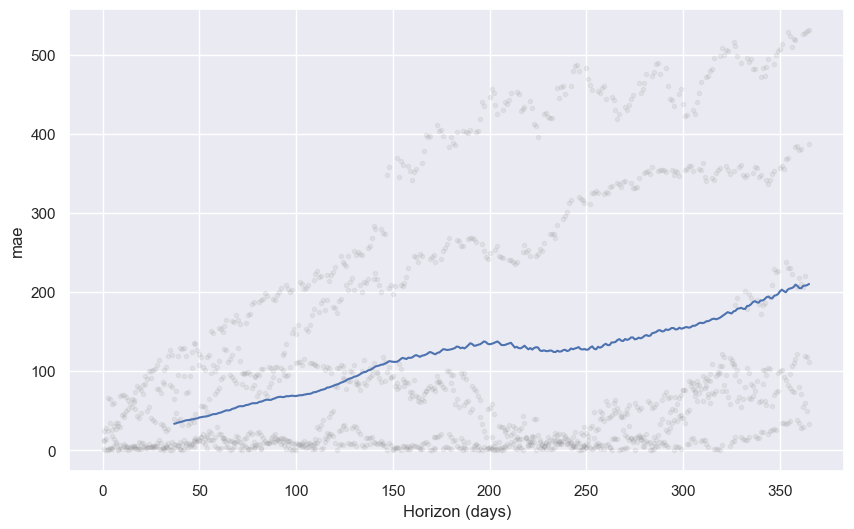

In [634]:
# Perform cross-validation
data_pr_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')

# Calculate error metrics
metrics = performance_metrics(data_pr_cv)
print(metrics)

# Plot performance metrics
fig = plot_cross_validation_metric(data_pr_cv, metric='mae')
plt.show()

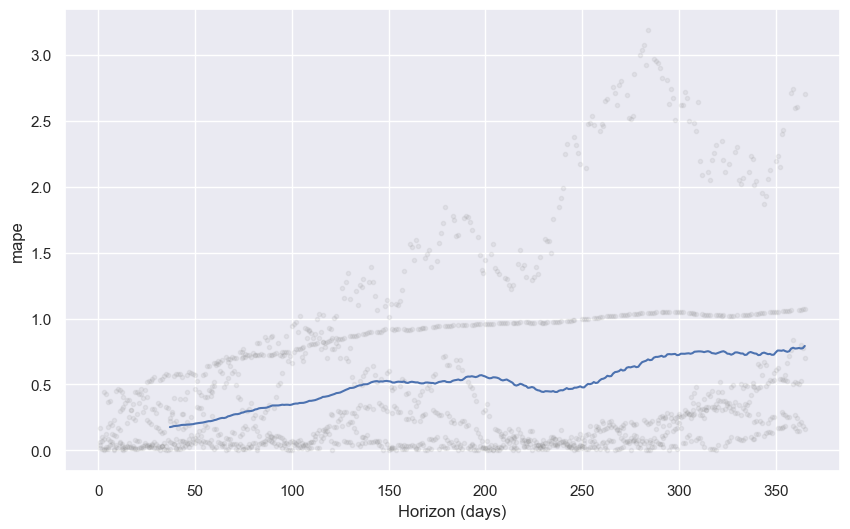

In [635]:
# Plot performance metrics
fig = plot_cross_validation_metric(data_pr_cv, metric='mape')
plt.show()

In [636]:
# Calculate the range of each metric
metric_ranges = metrics.describe().loc[['min', 'max']]
metric_ranges.loc['range'] = metric_ranges.loc['max'] - metric_ranges.loc['min']

# Print the range of each metric
print(metric_ranges)

                 horizon           mse        rmse         mae      mape  \
min     37 days 00:00:00   2349.721351   48.473924   33.485956  0.175838   
max    365 days 00:00:00  73852.944070  271.758982  210.247696  0.792197   
range  328 days 00:00:00  71503.222719  223.285057  176.761740  0.616359   

          mdape     smape  coverage  
min    0.071496  0.182734  0.136667  
max    0.520967  0.769223  0.651667  
range  0.449471  0.586489  0.515000  


#### Observation:
- Mean Squared Error (MSE):

The MSE measures the average squared difference between predicted and actual values.
    
Lower MSE values indicate better model performance.
    
Model’s MSE ranges from approximately 3668.64 to 116450 for different forecast horizons.
    
- Root Mean Squared Error (RMSE):

The RMSE is the square root of the MSE.

It represents the average absolute prediction error.
    
Model’s RMSE ranges from approximately 60.56 to 341.24.

- Mean Absolute Error (MAE):

The MAE measures the average absolute difference between predicted and actual values.
    
Lower MAE values indicate better accuracy.
    
Model’s MAE ranges from approximately 39.57 to 237.72.

- Mean Absolute Percentage Error (MAPE):

The MAPE expresses prediction errors as a percentage of the actual values.
    
Smaller MAPE values indicate better accuracy.

Model’s MAPE ranges from approximately 19.17% to 69.30%.

Peaks in MAPE suggest periods where the model struggled to make accurate predictions.

- Median Absolute Percentage Error (MDAPE):

The MDAPE is robust to outliers and represents the median percentage prediction error.

Lower MDAPE values indicate better performance.
    
Model’s MDAPE ranges from approximately 9.85% to 72.26%.

??? Can I conclude if my model works fine?????!

## Test other ML models

#### Plotting ACF and PACF

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

A autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

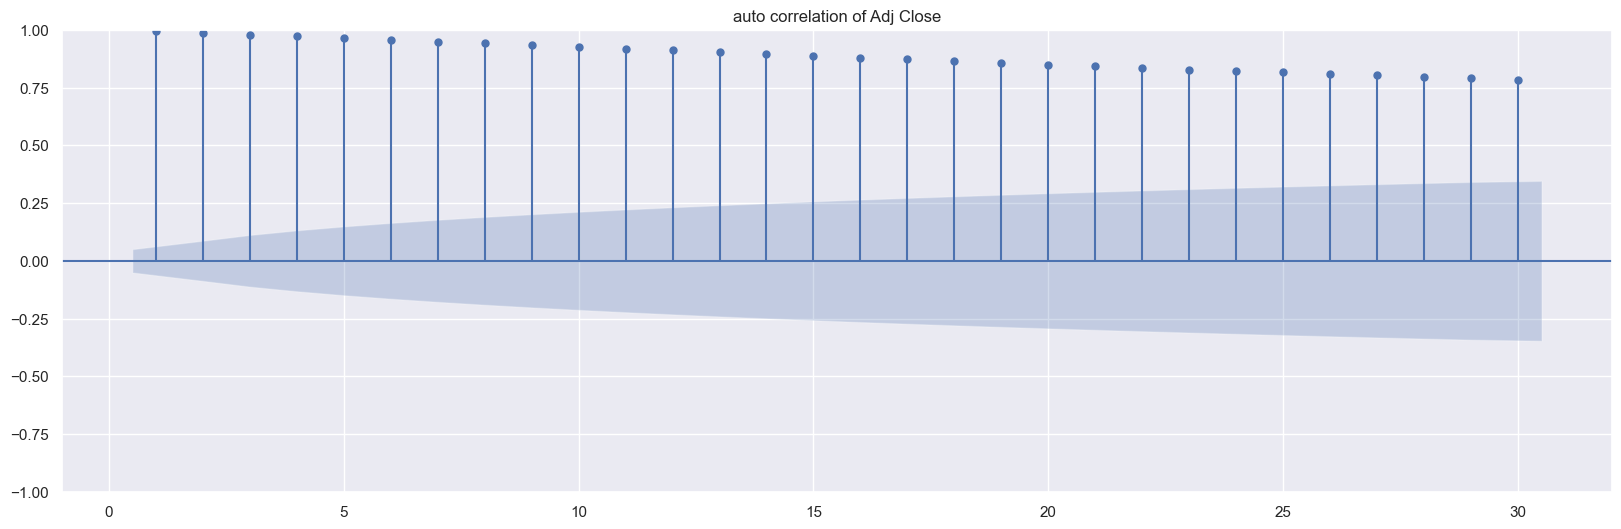

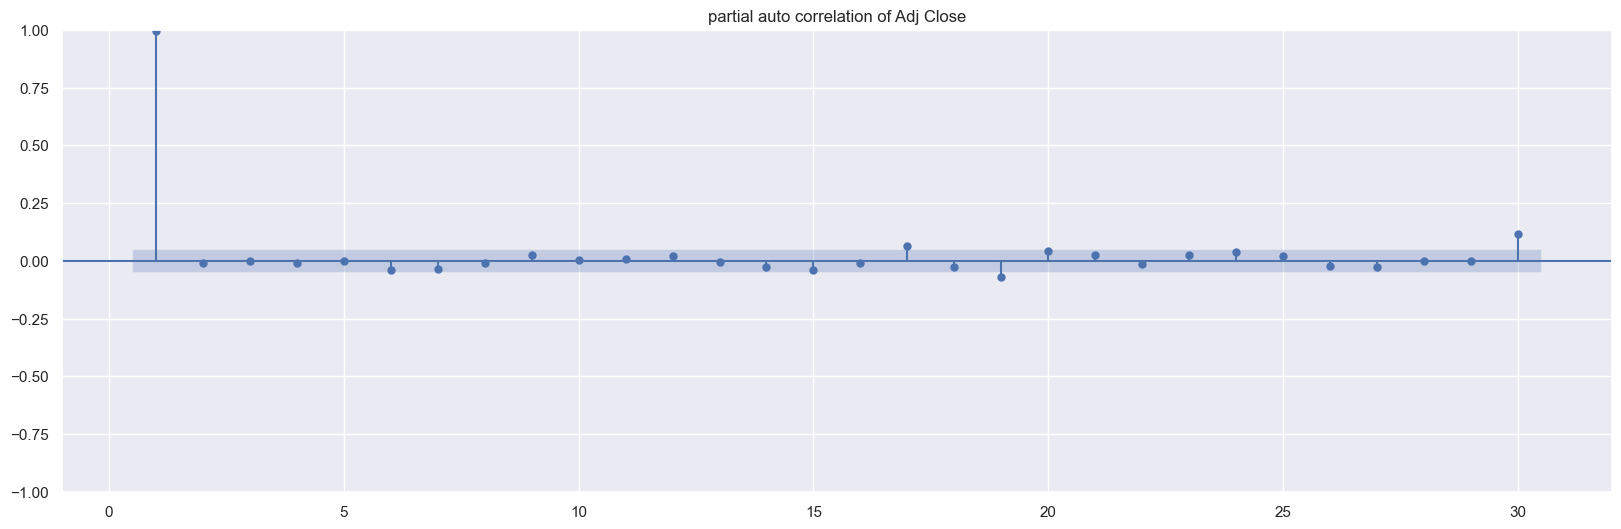

In [637]:
plt.rcParams.update({'figure.figsize': (20,6)})

sm.graphics.tsa.plot_acf(data['Close'], lags=30,title='auto correlation of Adj Close',zero=False);
sm.graphics.tsa.plot_pacf(data['Close'], lags=30,title='partial auto correlation of Adj Close',zero=False);

### LSTM

Epoch 1/50
37/37 - 1s - 15ms/step - loss: 0.0036 - val_loss: 0.0340
Epoch 2/50
37/37 - 0s - 3ms/step - loss: 1.4338e-04 - val_loss: 0.0156
Epoch 3/50
37/37 - 0s - 3ms/step - loss: 1.3170e-04 - val_loss: 0.0040
Epoch 4/50
37/37 - 0s - 3ms/step - loss: 1.1684e-04 - val_loss: 0.0020
Epoch 5/50
37/37 - 0s - 3ms/step - loss: 1.0983e-04 - val_loss: 0.0013
Epoch 6/50
37/37 - 0s - 3ms/step - loss: 1.0186e-04 - val_loss: 0.0019
Epoch 7/50
37/37 - 0s - 3ms/step - loss: 1.0644e-04 - val_loss: 0.0030
Epoch 8/50
37/37 - 0s - 3ms/step - loss: 9.2773e-05 - val_loss: 0.0034
Epoch 9/50
37/37 - 0s - 3ms/step - loss: 9.3299e-05 - val_loss: 0.0033
Epoch 10/50
37/37 - 0s - 3ms/step - loss: 8.9330e-05 - val_loss: 0.0040
Epoch 11/50
37/37 - 0s - 3ms/step - loss: 8.7627e-05 - val_loss: 0.0043
Epoch 12/50
37/37 - 0s - 3ms/step - loss: 8.3622e-05 - val_loss: 0.0039
Epoch 13/50
37/37 - 0s - 3ms/step - loss: 8.1074e-05 - val_loss: 0.0035
Epoch 14/50
37/37 - 0s - 3ms/step - loss: 8.2881e-05 - val_loss: 0.0042
Epoc

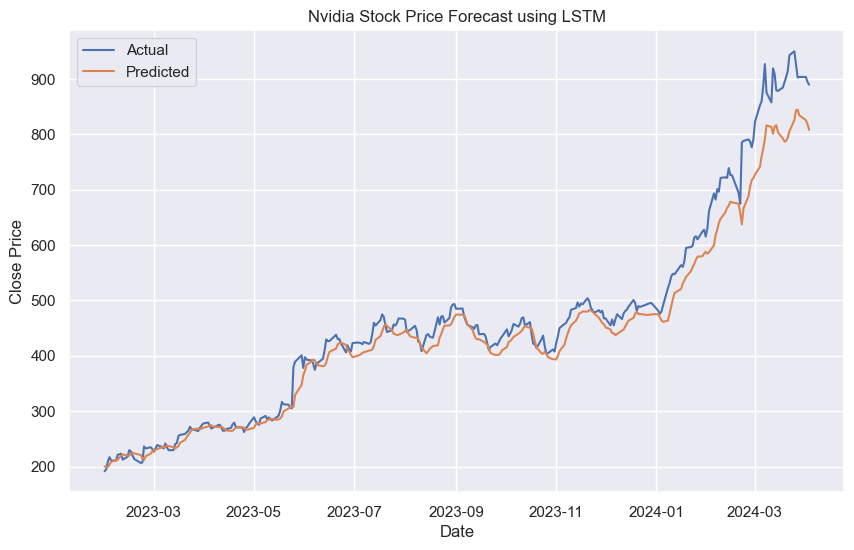

In [638]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data_lstm=df.copy()
data_lstm = data_lstm.drop(columns=['Dividends', 'Stock Splits'])
data_lstm.reset_index(inplace=True)
data_lstm

# Convert 'Date' column to datetime
data_lstm['Date'] = pd.to_datetime(data_lstm['Date'])

# Use 'Close' price as the target variable
target = data_lstm['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler.fit_transform(target)

# Define function to create input-output sequences
def create_sequences(data_lstm, seq_length):
    X, y = [], []
    for i in range(len(data_lstm) - seq_length):
        X.append(data_lstm[i:i+seq_length])
        y.append(data_lstm[i+seq_length])
    return np.array(X), np.array(y)


# Define sequence length (number of time steps to look back)
seq_length = 30

# Create input-output sequences
X, y = create_sequences(scaled_target, seq_length)

# Split the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=2)

model.save('lstm_model.keras')


# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate MAE
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print("Mean Absolute Error (MAE):", mae)

plt.figure(figsize=(10, 6))
plt.plot(data_lstm['Date'].iloc[split+seq_length:], y_test_inv, label='Actual')
plt.plot(data_lstm['Date'].iloc[split+seq_length:], y_pred_inv, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Nvidia Stock Price Forecast using LSTM')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


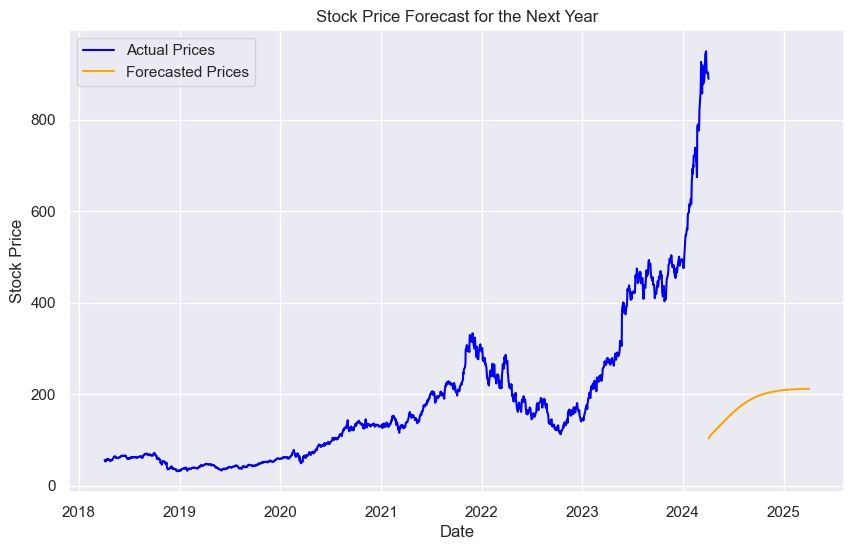

In [639]:
# Load the saved model
loaded_model = load_model('lstm_model.keras')

# Generate future dates
future_dates = pd.date_range(start=data_lstm['Date'].max() + pd.Timedelta(days=1), periods=365, freq='D')


# Find the minimum and maximum values of the historical data
min_value = np.min(scaled_target)
max_value = np.max(scaled_target)

# Prepare synthetic data for prediction
scaled_future_data = np.linspace(min_value, max_value, num=365).reshape(-1, 1)  # Use a range of values based on historical data

# Make predictions for each future time step
y_pred_future_inv = []
future_sequence = scaled_future_data[:seq_length].reshape(1, seq_length, 1)  # Initialize with the first sequence of future data
for i in range(365):
    # Predict the next time step
    y_pred = loaded_model.predict(future_sequence)
    
    # Append the prediction to the list of predictions
    y_pred_future_inv.append(scaler.inverse_transform(y_pred)[0, 0])
    
    # Update the future sequence for the next prediction
    future_sequence = np.concatenate([future_sequence[:, 1:, :], y_pred.reshape(1, 1, 1)], axis=1)

# Plot actual and forecasted stock prices
plt.figure(figsize=(10, 6))
plt.plot(data_lstm['Date'], data_lstm['Close'], label='Actual Prices', color='blue')
plt.plot(future_dates, y_pred_future_inv, label='Forecasted Prices', color='orange')
plt.title('Stock Price Forecast for the Next Year')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()



??? What am i doing wrong ??? :(

### ARIMA

Mean Absolute Error (MAE): 294.75776881512917


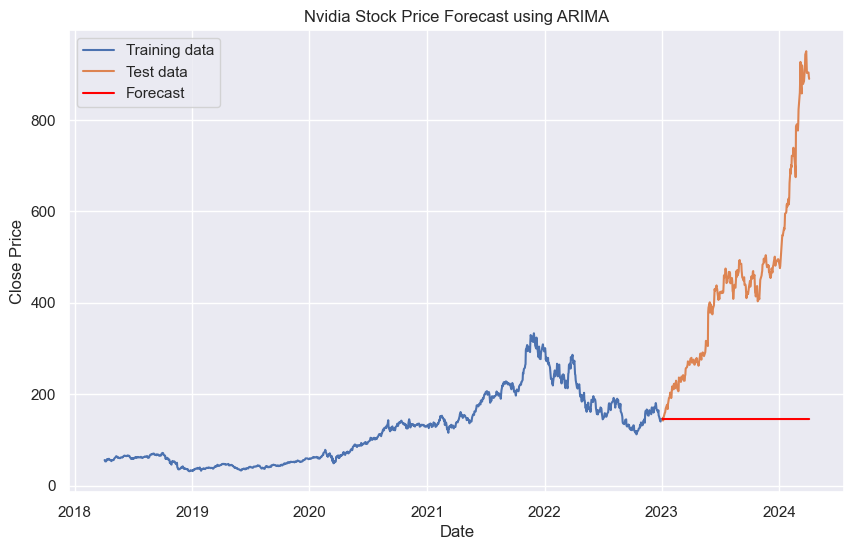

In [640]:
data=df.copy()
data = data.drop(columns=['Dividends', 'Stock Splits'])
data.reset_index(inplace=True)

# Set 'Date' column as index
data.set_index('Date', inplace=True)

# Split the data into training and testing sets
train = data[data.index < '2023']
test = data[data.index >= '2023']

# Fit ARIMA model
# ARIMA(p,d,q) where p is the order of the autoregressive model, d is the degree of differencing, and q is the order of the moving average model.
order = (5, 1, 0)  # Example order (to be tuned)
model = ARIMA(train['Close'], order=order)
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=len(test))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test['Close'], forecast)
print("Mean Absolute Error (MAE):", mae)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close'], label='Training data')
plt.plot(test.index, test['Close'], label='Test data')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Nvidia Stock Price Forecast using ARIMA')
plt.legend()
plt.grid(True)
plt.show()


#### Observation:
We examined our data and conclude that the data is not stationary, therefore I think Arima is not a good model for modelling and forcastin because it works fine with stationary data.

### Another LTSM approach

In [641]:
data=df.copy()
data = data.drop(columns=['Dividends', 'Stock Splits'])
data.reset_index(inplace=True)

trainData = data.iloc[:, 4:5].values
trainData.shape
(1260, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
trainData = scaler.fit_transform(trainData)
trainData

array([[0.02664667],
       [0.02533703],
       [0.0234157 ],
       ...,
       [0.94949363],
       [0.93957528],
       [0.93426226]])

In [642]:
# Processing sequence data
# To prepare the data for processing sequence data to be applied to recurrent neural networks (RNNs) for LSTM models.
# By creating overlapping sequences, allowing the model to learn and predict based on time series data patterns effectively. This helps the model recognize and utilize temporal patterns in the data.

X_train = []
y_train = []

for i in range(60, 1260):
    X_train.append(trainData[i-60:i, 0])
    y_train.append(trainData[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape
(1200, 60)
y_train.shape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1200, 60, 1)

In [643]:
# LSTM (Long Short-Term Memory)¶
# Sequential model, which is a deep learning model that allows us to stack layers sequentially.
# The first LSTM layer with 100 neurons and sets return_sequences=True to maintain the sequence data structure. The input_shape specifies the shape of the input data, which is set as (X_train.shape[1], 1).
# Dropout layers are added after each LSTM layer to prevent overfitting.
# The second, third, and fourth LSTM layers along with Dropout layers are added, creating a deep model.
# Lastly, a Dense layer is added as the output layer with one unit to generate the final predictions.
# The model.compile function is used to set the optimization method ('adam' in this case) and the loss function ('mean_squared_error').
model = Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [644]:
# Training the Deeplearning model¶
# X_train: typically contains the features or input data
# y_train: contains the target values
# epochs: The epochs parameter specifies the number of times the entire training dataset will be passed forward and backward through the neural network.
# batch_size: The batch_size parameter determines the number of training examples that are used in each iteration of gradient descent during training.
# verbose: The verbose parameter controls the level of output during training.
hist = model.fit(X_train, y_train, epochs = 20, batch_size = 32, verbose = 2)

Epoch 1/20
38/38 - 4s - 108ms/step - loss: 0.0018
Epoch 2/20
38/38 - 3s - 74ms/step - loss: 5.2890e-04
Epoch 3/20
38/38 - 3s - 75ms/step - loss: 4.5169e-04
Epoch 4/20
38/38 - 3s - 77ms/step - loss: 3.4750e-04
Epoch 5/20
38/38 - 3s - 78ms/step - loss: 3.6716e-04
Epoch 6/20
38/38 - 3s - 76ms/step - loss: 3.3553e-04
Epoch 7/20
38/38 - 3s - 76ms/step - loss: 2.7603e-04
Epoch 8/20
38/38 - 3s - 76ms/step - loss: 2.3689e-04
Epoch 9/20
38/38 - 3s - 76ms/step - loss: 2.5389e-04
Epoch 10/20
38/38 - 3s - 76ms/step - loss: 2.7289e-04
Epoch 11/20
38/38 - 3s - 76ms/step - loss: 2.3243e-04
Epoch 12/20
38/38 - 3s - 76ms/step - loss: 2.4339e-04
Epoch 13/20
38/38 - 3s - 76ms/step - loss: 2.3204e-04
Epoch 14/20
38/38 - 3s - 76ms/step - loss: 2.0617e-04
Epoch 15/20
38/38 - 3s - 76ms/step - loss: 2.1394e-04
Epoch 16/20
38/38 - 3s - 76ms/step - loss: 2.3672e-04
Epoch 17/20
38/38 - 3s - 76ms/step - loss: 1.8125e-04
Epoch 18/20
38/38 - 3s - 76ms/step - loss: 1.8768e-04
Epoch 19/20
38/38 - 3s - 74ms/step - los

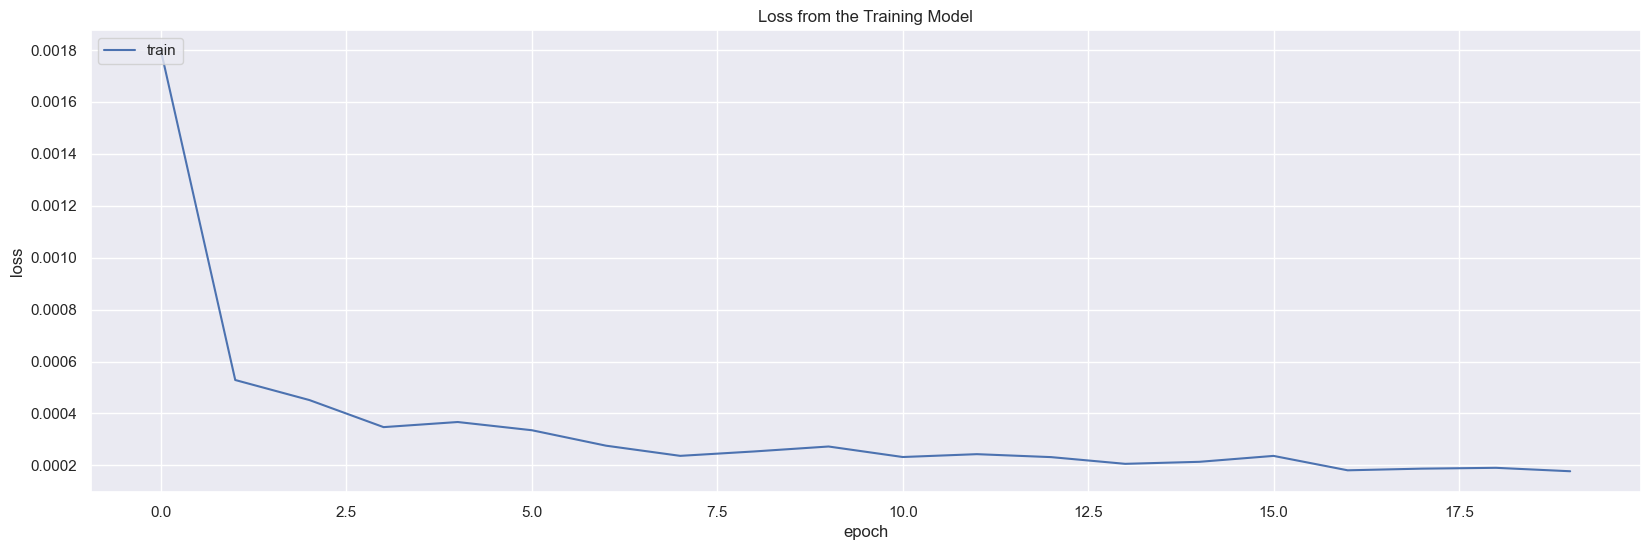

In [645]:
plt.plot(hist.history['loss'])
plt.title('Loss from the Training Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper left')
plt.show()

In [646]:
# Prediction Test with the model
testData=df.copy()
testData = testData.drop(columns=['Dividends', 'Stock Splits'])
testData.reset_index(inplace=True)

testData['Close'] = pd.to_numeric(testData.Close, errors = 'coerce')
testData = testData.dropna()
testData = testData.iloc[:, 4:5]
y_test = testData.iloc[60:, 0:].values
inputClosing = testData.iloc[:, 0:].values
inputClosing_scaled = scaler.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length):
    X_test.append(inputClosing_scaled[i-timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(1450, 60, 1)

In [647]:
y_pred = model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [648]:
predicted_price = scaler.inverse_transform(y_pred)

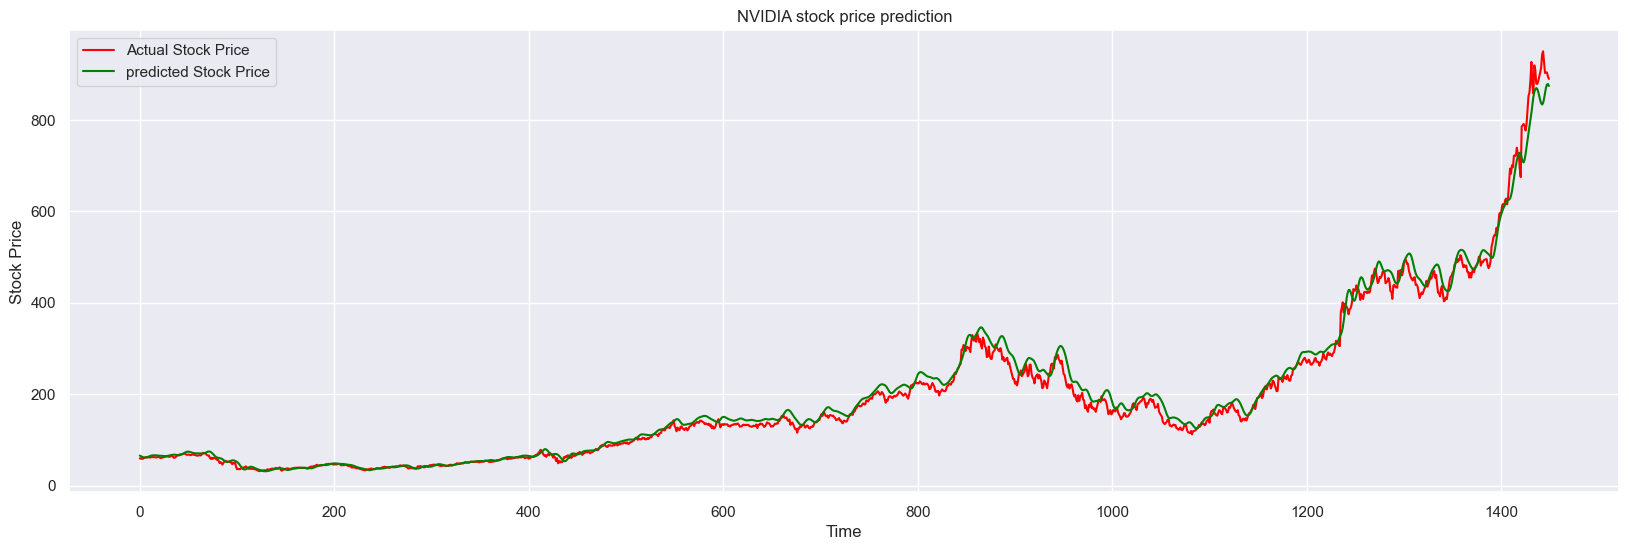

In [649]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(predicted_price, color = 'green', label = 'predicted Stock Price')
plt.title('NVIDIA stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

So the LTSM is the best model for forcasting the NVIDIA Stock data.